In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import scipy.io as sio
import importlib
import pathlib
import os
import sys
import pickle
import itertools 
import seaborn as sns
import copy

sys.path.append(os.path.join('..'))
import blrsmpc
from blrsmpc.sysid import sysid as sid

# Configure matplotlib and load notation from tex
blrsmpc.plotconfig.config_mpl(os.path.join('..', 'blrsmpc', 'plotconfig', 'notation.tex'))

# import sysid
# import helper
# import config_mpl
# importlib.reload(config_mpl)



# System identification meta analysis for the building system

Settings for the investigations.

In [10]:
settings = {
    'N': 12,
    'T_ini': 3,
    'train_samples': 1000,
    'test_samples': 300, 
    'state_feedback': False,
}

We investigate variants of the system with different process and measurement noise.
In particular, we define a base noise-level and multiply it with factors.

In [55]:
base_sig_x=np.array([0,0,0,0,0.5])
base_sig_y=1e-2

sig_x_fac = np.array([.1, 1, 2])
sig_y_fac = np.array([.1, 1, 2])

investigations = list(itertools.product(sig_x_fac, sig_y_fac))

print('Investigate the following combinations of sig_x_fac and sig_y_fac:')
pd.DataFrame(investigations, columns=['sig_x_fac', 'sig_y_fac'])

Investigate the following combinations of sig_x_fac and sig_y_fac:


,sig_x_fac,sig_y_fac
0,0.1,0.1
1,0.1,1.0
2,0.1,2.0
3,1.0,0.1
4,1.0,1.0
5,1.0,2.0
6,2.0,0.1
7,2.0,1.0
8,2.0,2.0


## Generate training data

For each case (defined by the noise levels), we generate a training data set:
- Create a ``sid.SystemGenerator`` object
- Configure the data generation with ``sid.DataGeneratorSetup``
- Define an input generator for the data generation. We choose random inputs with a maximum amplitude and random hold time.
- Create the training data with ``sid.DataGenerator``

In [56]:
np.random.seed(99)

train_data = []

for i, (sig_x_fac_i, sig_y_fac_i) in enumerate(investigations):
    sys_generator = sid.SystemGenerator(
        sys_type=sid.SystemType.BUILDING,
        sig_x=base_sig_x*sig_x_fac_i,
        sig_y=base_sig_y*sig_y_fac_i,
        dt=1,
        case_kwargs={'state_feedback': settings['state_feedback']}
    )

    data_gen_setup = sid.DataGeneratorSetup(
        T_ini=settings['T_ini'],
        N=settings['N'],
        n_samples=settings['train_samples'],
    )
    # Class that generates a pseudo-random input signal
    random_input = sid.RandomInput(
        n_u=5, 
        u_lb = np.array([-6,-6,-6,-6, 0]).reshape(-1,1),
        u_ub = np.array([6,6,6,6,30]).reshape(-1,1),
        switch_prob=np.array([0.5, 0.5, 0.5, 0.5, 0.04]).reshape(-1,1)
        )
    
    # Generate data
    train_data.append(sid.DataGenerator(sys_generator, data_gen_setup, random_input))
    print(f'{i+1} of {len(investigations)} data sets generated: ')

1 of 9 data sets generated: ███████████████████████████████████████████] 100.0% done
2 of 9 data sets generated: ███████████████████████████████████████████] 100.0% done
3 of 9 data sets generated: ███████████████████████████████████████████] 100.0% done
4 of 9 data sets generated: ███████████████████████████████████████████] 100.0% done
5 of 9 data sets generated: ███████████████████████████████████████████] 100.0% done
6 of 9 data sets generated: ███████████████████████████████████████████] 100.0% done
7 of 9 data sets generated: ███████████████████████████████████████████] 100.0% done
8 of 9 data sets generated: ███████████████████████████████████████████] 100.0% done
9 of 9 data sets generated: ███████████████████████████████████████████] 100.0% done


In [57]:
print(f'Checksum to ensure identical results should be 1467.2538. It is {train_data[0].sim_results[0].x.sum()}')

Checksum to ensure identical results should be 1467.2538. It is 1467.2538608090042


## Generate test data

For each case (defined by the noise levels), we generate a test data set similar to the training data.
Minor differences are:
- We use the same random input sequence for all cases, and the same initial state. This is achieved by generating the ``sid.InputFromSequence`` object before the loop.
- For the past horizon of lenght ``T_ini`` we use the same realizations of process and measurement noise. 


In [59]:
np.random.seed(21)

test_data = []
test_data_true_cov = []

# Generate the same input sequence for all test cases 
random_input_sequence = random_input.gen_sequence(settings['N'])
# Input object that returns the same input sequence
sequence_input = sid.InputFromSequence(random_input_sequence)
# Initial state (identical for all test cases) 
x0_test =np.array([20, 20.5, 19.5, 21, 10]).reshape(-1,1) 

for i, (sig_x_fac_i, sig_y_fac_i) in enumerate(investigations):

    # For all samples use a system with the same initial sequence of process and meas. noise
    test_sys_ref = sid.SystemGenerator(
            sys_type=sys_generator.sys_type,
            sig_x=base_sig_x*sig_x_fac_i,
            sig_y=base_sig_y*sig_y_fac_i,
            dt=sys_generator.dt,
            P0 = np.zeros((5,5)),
            case_kwargs={
                'state_feedback': settings['state_feedback'],
                'x0': x0_test
            },
    )()
    test_sys_ref.simulate(sequence_input, settings['T_ini'])

    def test_sys_generator():
        return copy.deepcopy(test_sys_ref)
    
    # Test data
    test_data_setup = sid.DataGeneratorSetup(
        T_ini=data_gen_setup.T_ini,
        N=data_gen_setup.N-data_gen_setup.T_ini,
        n_samples=settings['test_samples'],
    )

    # Generate test data
    test_data.append(sid.DataGenerator(test_sys_generator, test_data_setup, sequence_input))
    print(f'{i+1} of {len(investigations)} data sets generated: ')

1 of 9 data sets generated: ███████████████████████████████████████████] 100.0% done
2 of 9 data sets generated: ███████████████████████████████████████████] 100.0% done
3 of 9 data sets generated: ███████████████████████████████████████████] 100.0% done
4 of 9 data sets generated: ███████████████████████████████████████████] 100.0% done
5 of 9 data sets generated: ███████████████████████████████████████████] 100.0% done
6 of 9 data sets generated: ███████████████████████████████████████████] 100.0% done
7 of 9 data sets generated: ███████████████████████████████████████████] 100.0% done
8 of 9 data sets generated: ███████████████████████████████████████████] 100.0% done
9 of 9 data sets generated: ███████████████████████████████████████████] 100.0% done


In [60]:
print(f'Checksum to ensure identical results should be 1282.631507 It is {test_data[0].sim_results[0].x.sum()}')

Checksum to ensure identical results should be 1282.631507 It is 1282.6315074931013


Displaying test data for the different cases. We plot the A single sequence of outputs of the system for each combination of noise levels and show the uncertainty as the three-sigma range.

Text(0.5, 0.98, 'Test data ')

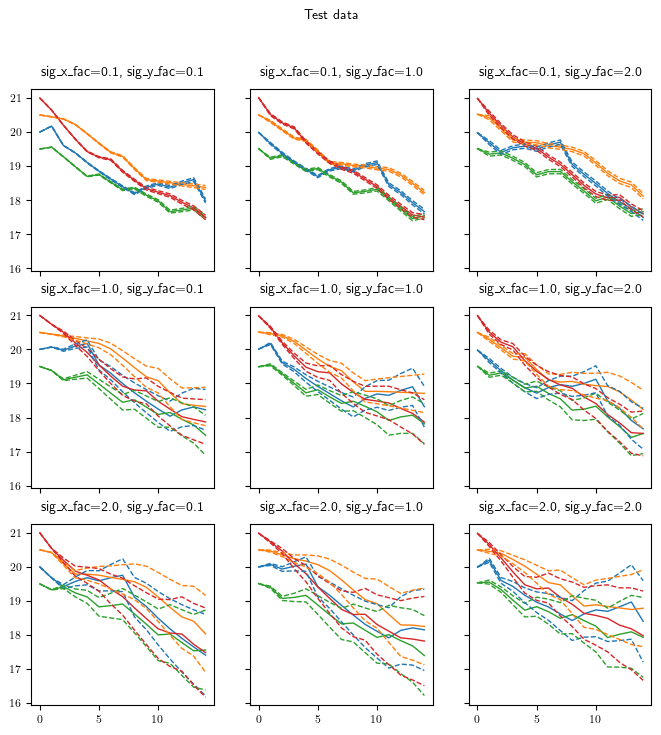

In [61]:
fig, ax = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=True)

for i, test_data_i in enumerate(test_data):
    k,j = np.unravel_index(i, (3,3))
    std = np.sqrt(np.diagonal(test_data_i.sim_results[0].P_y, axis1=1, axis2=2))
    
    ax[k,j].plot(test_data_i.sim_results[0].y)
    ax[k,j].set_prop_cycle(None)
    ax[k,j].plot(test_data_i.sim_results[0].y+3*std, linestyle='--')
    ax[k,j].set_prop_cycle(None)
    ax[k,j].plot(test_data_i.sim_results[0].y-3*std, linestyle='--')
    ax[k,j].set_title(f'sig_x_fac={investigations[i][0]}, sig_y_fac={investigations[i][1]}', fontsize=10)

fig.suptitle('Test data ')


## System identification

We identify system models in the form of a:
- state-space model ``sid.StateSpaceModel``
- multi-step model ``sid.MultistepModel`` 

For both models, we evaluate the performance of the identified model on the test data.

In [81]:
%%capture

results = []

for i, (train_data_i, test_data_i) in enumerate(zip(train_data, test_data)):
    if i==0:
        msm = sid.MultistepModel(estimate_covariance=True, scale_x=False, scale_y=False, add_bias=True)
        ssm = sid.StateSpaceModel(estimate_covariance=True, scale_x=False, scale_y=False, add_bias=True)
    msm.fit(train_data_i)
    ssm.fit(train_data_i)

    y_msm_pred, y_msm_pred_std = msm.predict(test_data_i.M[:,[0]].T, uncert_type="std", with_noise_variance=True)
    y_msm_pred = y_msm_pred.reshape(-1,test_data_i.n_y)
    y_msm_pred_std = y_msm_pred_std.reshape(-1,test_data_i.n_y)
    y_ssm_pred, y_ssm_pred_std = ssm.predict_sequence(test_data_i.M[:,[0]], with_noise_variance=True)

    msm_cov_final = msm.predict(test_data_i.M[:,[0]].T, uncert_type="cov", with_noise_variance=True)[1][-test_data_i.n_y:, -test_data_i.n_y:]

    results.append(
        {
            'y_msm_pred': y_msm_pred,
            'y_msm_pred_std': y_msm_pred_std,
            'y_ssm_pred': y_ssm_pred,
            'y_ssm_pred_std': y_ssm_pred_std,
            'msm_cov_final': msm_cov_final,
        }
    )

### Investigations

We start by investigating covariance matrices of the identified multi-step model.

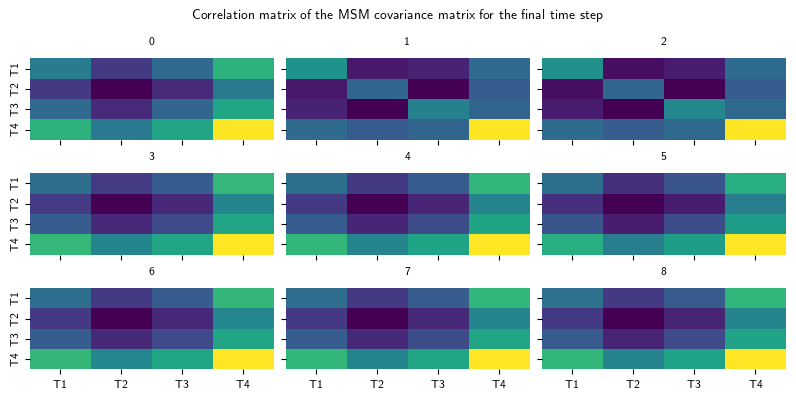

In [82]:
fig, ax = plt.subplots(3, 3, figsize=(8, 4), sharex=True, sharey=True)

for i, (test_data_i, results_i) in enumerate(zip(test_data, results)):
    k,j = np.unravel_index(i, (3,3))

    names = ['T1', 'T2', 'T3', 'T4']

    if settings['state_feedback']:
        cov = results_i['msm_cov_final'][:-1,:-1]
    else:
        cov = results_i['msm_cov_final']

    corr = pd.DataFrame(cov, index=names, columns=names)

    sns.heatmap(corr, ax=ax[k,j], cmap='viridis', cbar=False)
    ax[k,j].set_title(f'{i}')

fig.suptitle('Correlation matrix of the MSM covariance matrix for the final time step')
fig.tight_layout()

Text(0, 0.5, 'T2')

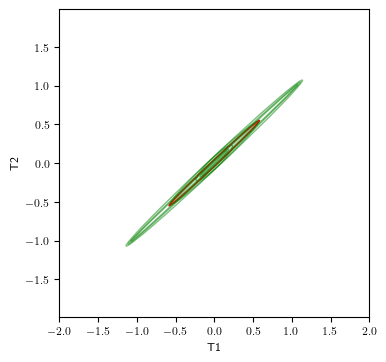

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharex=True, sharey=True)

ax.axis('equal')

for k in range(len(investigations)):
    cov = results[k]['msm_cov_final']
    blrsmpc.helper.plot_cov_as_ellipse(0, 0, cov, ax=ax, facecolor='none', edgecolor='g', linewidth=1, alpha=.5)
    if k == 4:
        cov = results[k]['msm_cov_final']
        blrsmpc.helper.plot_cov_as_ellipse(0, 0, cov, ax=ax, facecolor='none', edgecolor='r', linewidth=1, alpha=1)


ax.set_xlim(-2, 2)
ax.set_ylim(-2,2)

ax.set_xlabel('T1')
ax.set_ylabel('T2')

We then plot an open-loop trajectory of the identified models including the uncertainty as the three-sigma range.

In [84]:
def get_plot(result, test_data):
    fig, ax = plt.subplots(test_data.n_y,1, sharex=True, figsize=(10,5))

    t_ini = test_data.setup.T_ini

    y_msm_pred = result['y_msm_pred']
    y_msm_pred_std = result['y_msm_pred_std']
    y_ssm_pred = result['y_ssm_pred']
    y_ssm_pred_std = result['y_ssm_pred_std']

    Y_pred = np.stack([sample.y[settings['T_ini']:] for sample in test_data.sim_results],axis=2)

    t = test_data.sim_results[0].time[settings['T_ini']:]
    for i in range(test_data.n_y):
        ax[i].plot(t, Y_pred[:,i,:], color='k',linewidth=1, alpha=0.05)

        ax[i].plot(t, y_ssm_pred[:,i],linewidth=2, label="SSM")
        # ax[i].fill_between(t, y_ssm_pred[:,i]-3*y_ssm_pred_std[:,i], y_ssm_pred[:,i]+3*y_ssm_pred_std[:,i], alpha=0.3)

        ax[i].plot(t, y_msm_pred[:,i], '--', linewidth=2, label="MSM")
        ax[i].fill_between(t, y_msm_pred[:,i]-3*y_msm_pred_std[:,i], y_msm_pred[:,i]+3*y_msm_pred_std[:,i], alpha=0.3)

    ax[0].plot([],[], color='k', linewidth=1, alpha=0.2, label="Samples")

    ax[0].legend()

    return fig, ax

Text(0.5, 0.98, '$\\sigma_x$=1.0, $\\sigma_y$=1.0')

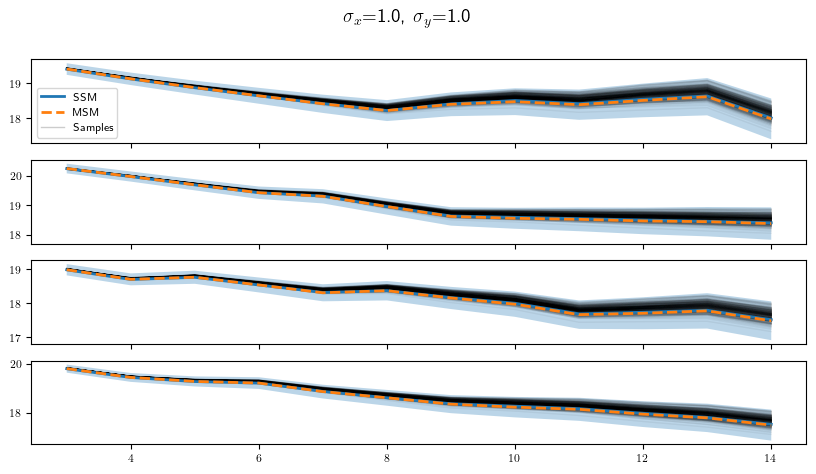

In [85]:
plot_case = 4

fig, ax = get_plot(results[plot_case], test_data[plot_case])
fig.suptitle(f'$\sigma_x$={investigations[plot_case][0]}, $\sigma_y$={investigations[plot_case][1]}', fontsize=14)

### Performance metrics

In [89]:
def get_normalized_distance(Y_true, y_pred, y_pred_std):
    norm_dist = np.abs(Y_true-np.atleast_3d(y_pred))/np.atleast_3d(y_pred_std)
    return norm_dist

def get_ratio_to_true_std(y_pred_std, true_std):
    ratio = y_pred_std/true_std
    return ratio

def get_stats(Y_true, y_pred, y_pred_std, true_std):
    norm_dist = np.percentile(get_normalized_distance(Y_true, y_pred, y_pred_std), 99.7)
    in_three_sigma = np.sum(norm_dist < 3)/np.prod(norm_dist.shape)*100
    mse = np.mean((Y_true-np.atleast_3d(y_pred))**2)
    ratio_to_true_std = np.mean(get_ratio_to_true_std(y_pred_std, true_std))

    return in_three_sigma, mse, ratio_to_true_std, norm_dist

In [90]:
results_post_proc = {
    'sigma_x': [],
    'sigma_y': [],
    'msm': {
        'perc. in 3 sigma': [],
        'ratio to true std': [],
        'norm_distance': [],
        'mse': [],
    },
    'ssm': {
        'perc. in 3 sigma': [],
        'ratio to true std': [],
        'norm_distance': [],
        'mse': [],
    },
}

for i, (test_data_i, results_i) in enumerate(zip(test_data, results)):
    Y_pred = np.stack([sample.y[settings['T_ini']:] for sample in test_data_i.sim_results],axis=2)
    true_std = np.sqrt(np.diagonal(test_data_i.sim_results[0].P_y, axis1=1, axis2=2))[data_gen_setup.T_ini:]

    stats_msm = get_stats(Y_pred, results_i['y_msm_pred'], results_i['y_msm_pred_std'], true_std)
    stats_ssm = get_stats(Y_pred, results_i['y_ssm_pred'], results_i['y_ssm_pred_std'], true_std)

    results_post_proc['msm']['perc. in 3 sigma'].append(stats_msm[0])
    results_post_proc['msm']['mse'].append(stats_msm[1])
    results_post_proc['msm']['ratio to true std'].append(stats_msm[2])
    results_post_proc['msm']['norm_distance'].append(stats_msm[3])
    results_post_proc['ssm']['perc. in 3 sigma'].append(stats_ssm[0])
    results_post_proc['ssm']['mse'].append(stats_ssm[1])
    results_post_proc['ssm']['ratio to true std'].append(stats_ssm[2])
    results_post_proc['ssm']['norm_distance'].append(stats_ssm[3])

    results_post_proc['sigma_x'].append(investigations[i][0])
    results_post_proc['sigma_y'].append(investigations[i][1])

# Normalize mse with smallest value
min_mse = np.min(np.concatenate([results_post_proc['msm']['mse'], results_post_proc['ssm']['mse']]))

print(min_mse)
    


0.0001150742087355131


In [91]:
d1 = pd.DataFrame(results_post_proc['msm'])
d2 = pd.DataFrame(results_post_proc['ssm'])

df_case = pd.DataFrame({'sigma_x': results_post_proc['sigma_x'], 'sigma_y': results_post_proc['sigma_y']})


df = pd.concat([df_case, d1,d2], keys=['empty', 'MSM', 'SSM'],axis=1)

df['MSM']['mse'] /= min_mse
df['SSM']['mse'] /= min_mse


df

/var/folders/rw/cwpn4qds40s2_r4x82fq8sph0000gn/T/ipykernel_35539/3424372426.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MSM']['mse'] /= min_mse
/var/folders/rw/cwpn4qds40s2_r4x82fq8sph0000gn/T/ipykernel_35539/3424372426.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SSM']['mse'] /= min_mse


empty                      MSM                                  \
  sigma_x sigma_y perc. in 3 sigma ratio to true std norm_distance   
0     0.1     0.1            100.0          7.455292      0.747499   
1     0.1     1.0            100.0          3.964605      1.422943   
2     0.1     2.0            100.0          2.943957      1.210364   
3     1.0     0.1            100.0          1.187322      2.389555   
4     1.0     1.0            100.0          1.210043      2.600482   
5     1.0     2.0            100.0          1.190039      2.461651   
6     2.0     0.1            100.0          0.924099      2.619924   
7     2.0     1.0            100.0          0.950235      2.028040   
8     2.0     2.0            100.0          0.994730      2.102336   

                           SSM                                              
          mse perc. in 3 sigma ratio to true std norm_distance         mse  
0    1.000000            100.0         30.137437      0.073954    1.204353  
1    9.300002            100.0         18.008583      0.507654    6.654626  
2    8.164073            100.0         12.638767      0.773838    6.323921  
3  103.289469            100.0          3.925411      0.453293   77.262212  
4  149.294263            100.0          3.147925      0.709797  121.546710  
5  113.659710            100.0          2.880257      0.808622   77.506210  
6  530.946465            100.0          2.220615      0.904488  492.321884  
7  230.850178            100.0          1.906764      0.871220  226.412275  
8  266.599787            100.0          1.759427      1.129499  252.090681

In [71]:
tex_str = df.to_latex(
    float_format='{:0.1f}'.format,
    multicolumn=True,
    multirow=True,
    index=False,
)

tex_str = tex_str.replace('perc. in 3 sigma', r'in $\pm3\sigma$')
tex_str = tex_str.replace('ratio to true std', r'$\hat\sigma/\sigma$')
tex_str = tex_str.replace('sigma\\_x', r'$\alpha_{\sigma_a}$')
tex_str = tex_str.replace('sigma\\_y', r'$\alpha_{\sigma_r}$')
tex_str = tex_str.replace('mse', r'MSE$^*$')
tex_str = tex_str.replace('empty', r'&')


tex_str_list = tex_str.split('\n')

tex_str_list.insert(3, r'\cmidrule(lr){3-5} \cmidrule(lr){6-8}')

tex_str_list.pop(1) # Remove toprule

tex_str =  '\n'.join(tex_str_list)

savepath = os.path.join('..', '..', '2023_CDC_L-CSS_Paper_Stochastic_MSM', 'tables')
savename = 'sid_results_matrix.tex'

# with open(os.path.join(savepath, savename), 'w') as f:
#     f.write(tex_str)


/var/folders/rw/cwpn4qds40s2_r4x82fq8sph0000gn/T/ipykernel_35539/2537297372.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex_str = df.to_latex(


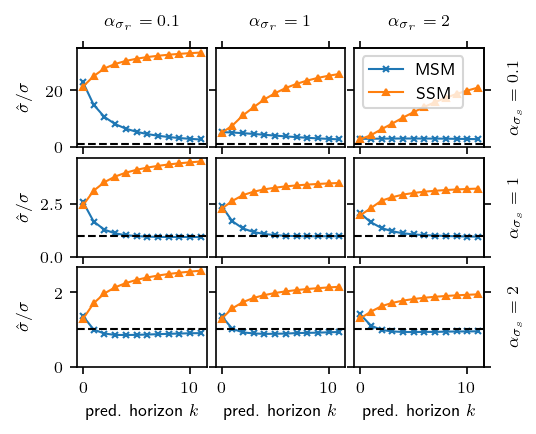

In [92]:

fig, ax = plt.subplots(3, 3, figsize=(blrsmpc.plotconfig.columnwidth, .8*blrsmpc.plotconfig.columnwidth), sharex=True, sharey='row', dpi=150)

for i, (test_data_i, results_i) in enumerate(zip(test_data, results)):
    k,j = np.unravel_index(i, (3,3))
    
    Y_pred = np.stack([sample.y[settings['T_ini']:] for sample in test_data_i.sim_results],axis=2)

    true_std = (np.sqrt(np.diagonal(test_data_i.sim_results[0].P_y, axis1=1, axis2=2)))[data_gen_setup.T_ini:]
    mean_ratio_true_std_msm = np.mean(get_ratio_to_true_std(results_i['y_msm_pred_std'], true_std), axis=1)
    mean_ratio_true_std_ssm = np.mean(get_ratio_to_true_std(results_i['y_ssm_pred_std'], true_std), axis=1)

    
    ax[k,j].plot(mean_ratio_true_std_msm, '-x', label='MSM', markersize=3)
    ax[k,j].plot(mean_ratio_true_std_ssm, '-^', label='SSM', markersize=3)    
    ax[k,j].axhline(1, color='k', linestyle='--')

    ax[k,j].set_ylim(0, None)



ax[0,0].set_ylabel(r'$\hat\sigma / \sigma$')
ax[1,0].set_ylabel(r'$\hat\sigma / \sigma$')
ax[2,0].set_ylabel(r'$\hat\sigma / \sigma$')

ax[2,0].set_xlabel(r'pred. horizon $k$')
ax[2,1].set_xlabel(r'pred. horizon $k$')
ax[2,2].set_xlabel(r'pred. horizon $k$')

sec_x_axis = []
sec_y_axis = []
for i in range(3):
    sec_x_axis.append(ax[0,i].secondary_xaxis('top'))
    sec_y_axis.append(ax[i,-1].secondary_yaxis('right'))

    sec_x_axis[i].xaxis.set_ticklabels([])
    sec_y_axis[i].yaxis.set_ticklabels([])

sec_y_axis[0].set_ylabel(r'$\alpha_{\sigma_s} = 0.1$')
sec_y_axis[1].set_ylabel(r'$\alpha_{\sigma_s} = 1$')
sec_y_axis[2].set_ylabel(r'$\alpha_{\sigma_s} = 2$')

sec_x_axis[0].set_xlabel(r'$\alpha_{\sigma_r} = 0.1$')
sec_x_axis[1].set_xlabel(r'$\alpha_{\sigma_r} = 1$')
sec_x_axis[2].set_xlabel(r'$\alpha_{\sigma_r} = 2$')



ax[0,2].legend()


fig.tight_layout(pad = 0.1)
fig.align_labels()

savepath = os.path.join('..', '..', '2023_CDC_L-CSS_Paper_Stochastic_MSM', 'figures')
savename = 'ratio_ident_vs_true_std'
# fig.savefig(os.path.join(savepath, savename + '.pgf'), bbox_inches='tight', format='pgf')

## Export model

Fit again the model that should be exported. We are fitting again, because we didn't want to save all the intermediate results.

In [93]:
%%capture

export_id = 4

train_data_i = train_data[export_id]
msm = sid.MultistepModel(estimate_covariance=True, scale_x=False, scale_y=False, add_bias=True)
ssm = sid.StateSpaceModel(estimate_covariance=True, scale_x=False, scale_y=False, add_bias=True)
msm.fit(train_data_i)
ssm.fit(train_data_i)

sig_x_fac_i, sig_y_fac_i = investigations[export_id]
sigma_x=base_sig_x*sig_x_fac_i
sigma_y=base_sig_y*sig_y_fac_i


In [101]:

result_dir = os.path.join('sid_results')
save_name = "02_building_prediction_models.pkl"
save_name = os.path.join(result_dir, save_name)

pathlib.Path(result_dir).mkdir(parents=True, exist_ok=True)

with open(save_name, "wb") as f:
    res = {'msm': msm, 'ssm': ssm, 'sigma_x': sigma_x, 'sigma_y': sigma_y}
    pickle.dump(res, f)

Check if loading works

In [102]:
with open(save_name, "rb") as f:
    res = pickle.load(f)